# Dogs vs. Cats Classification

## 1. Import inquired liberies

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load data

In [2]:
df = pd.read_csv('cat_dog_df.csv')
df.head(10)

,file_name,type
0,/data/aia-data/cat_dog/train/cat.8852.jpg,0
1,/data/aia-data/cat_dog/train/cat.11428.jpg,0
2,/data/aia-data/cat_dog/train/cat.12315.jpg,0
3,/data/aia-data/cat_dog/train/dog.4577.jpg,1
4,/data/aia-data/cat_dog/train/cat.3228.jpg,0
5,/data/aia-data/cat_dog/train/dog.10232.jpg,1
6,/data/aia-data/cat_dog/train/cat.11895.jpg,0
7,/data/aia-data/cat_dog/train/cat.1361.jpg,0
8,/data/aia-data/cat_dog/train/dog.8190.jpg,1
9,/data/aia-data/cat_dog/train/cat.546.jpg,0


### Hint: use cv2 to read jpg files

(313, 400)


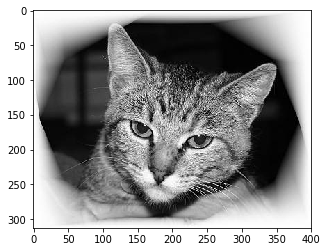

In [3]:
pic = cv2.imread(df.file_name[0], cv2.IMREAD_GRAYSCALE)
print(pic.shape)
plt.imshow(pic, cmap='gray')
plt.show()

In [4]:
# #show original color image

# pic = cv2.imread(df.file_name[0], cv2.IMREAD_UNCHANGED)
# print(pic.shape)
# plt.imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
# plt.show()

In [5]:
# picsize = 128
# pic = cv2.resize(pic, (picsize, picsize))
# plt.imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
# plt.show()

## 3. Split data and do preprocessing

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.type)

def df_to_data(df, picsize):
    img_ls = []
    label_ls = []

#     file_names = df.file_name.tolist()
#     labels = df.type.tolist()
#     for i in tqdm_notebook(range(len(df.type))):
        
#         file_name = file_names[i]
#         label = labels[i] 
  
    for file_name, label in tqdm_notebook(zip(df.file_name, df.type)):
    
        img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (picsize, picsize))
        img_ls.append(img)
        
        # convert binary classification to c-class classfication problem with c = 2
        onehot = np.zeros(2)  
        onehot[label] = 1
        label_ls.append(onehot)

    #numpy reshape
    x_data = np.array(img_ls).reshape(len(df), -1)  # flatten image data
#     print('x_data.shape = ', x_data.shape)
    x_data = x_data / 255.  # normalization
    y_data = np.array(label_ls)
    return x_data, y_data
#test code
picsize = 128
x,y = df_to_data(train_df, 128)

In [7]:
picsize = 64
X_train, y_train = df_to_data(train_df, picsize)
X_test, y_test = df_to_data(test_df, picsize)

print('size of training data:', X_train.shape, y_train.shape)
print('size of testing data:', X_test.shape, y_test.shape)


size of training data: (20000, 4096) (20000, 2)
size of testing data: (5000, 4096) (5000, 2)


## 4. Build the network

In [8]:
tf.reset_default_graph()

with tf.name_scope('placeholder'):
    input_data = tf.placeholder(tf.float32, shape=[None, picsize*picsize], name='X')
    y_true = tf.placeholder(tf.float32, shape=[None, 2], name='y')
    
with tf.variable_scope('network'):
    h1 = tf.layers.dense(input_data, 256, activation=tf.nn.sigmoid, name='hidden1')  # try to change the activation function
    h2 = tf.layers.dense(h1, 128, activation=tf.nn.sigmoid, name='hidden2') 
    h3 = tf.layers.dense(h2, 64, activation=tf.nn.sigmoid, name='hidden3')
    out = tf.layers.dense(h3, 2, name='output')
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), name='loss')
    
with tf.name_scope('accuracy'):
#     print('out.shape=',out.shape)
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.name_scope('opt'):
    update = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss) # try to change the optimuizer and learning rate
    
init = tf.global_variables_initializer()

In [9]:
tf.global_variables()

[<tf.Variable 'network/hidden1/kernel:0' shape=(4096, 256) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'network/hidden3/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'network/hidden3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'network/output/kernel:0' shape=(64, 2) dtype=float32_ref>,
 <tf.Variable 'network/output/bias:0' shape=(2,) dtype=float32_ref>]

In [10]:
var_sum = 0
for tensor in tf.global_variables(scope='network'):
    if 'Adam' not in tensor.name:
#         print(tensor.name)
#         print(tensor.shape)
#         var_sum += np.product(tensor.shape.as_list())
        var_sum += np.product(tensor.shape)
    
print('the total number of weights is', var_sum)  # 4096*256 + 256 + 256*128 + 128 + 128*64 + 64 + 64*2 + 2

the total number of weights is 1090114


In [11]:
# np.product((1,2))

In [12]:
# np.product([1,2,3,4])

In [13]:
epoch = 100
bs = 128 # original is 32 I think

train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

sess = tf.Session()
sess.run(init)

for i in tqdm_notebook(range(epoch)):
    
#     training part
    train_loss_batch, train_acc_batch = [], []
    
    total_batch = len(X_train) // bs
    
    for j in range(total_batch):
        
        X_batch = X_train[j*bs : (j+1)*bs]
        y_batch = y_train[j*bs : (j+1)*bs]
        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                            feed_dict={input_data: X_batch, y_true: y_batch})
        
        train_loss_batch.append(batch_loss)
        train_acc_batch.append(batch_acc)
        
    train_loss_epoch.append(np.mean(train_loss_batch))
    train_acc_epoch.append(np.mean(train_acc_batch))
    
#     testing part
    batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                    feed_dict={input_data: X_test, y_true: y_test})

    test_loss_epoch.append(batch_loss)
    test_acc_epoch.append(batch_acc)
    
    X_train, y_train = shuffle(X_train, y_train)
    
    if i%5 == 0:
        print('step: {:2d}, train loss: {:.3f}, train acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}'
             .format(i, train_loss_epoch[i], train_acc_epoch[i], test_loss_epoch[i], test_acc_epoch[i]))
    

step:  0, train loss: 0.728, train acc: 0.500, test loss: 0.698, test acc: 0.500
step:  5, train loss: 0.693, train acc: 0.486, test loss: 0.693, test acc: 0.498
step: 10, train loss: 0.693, train acc: 0.498, test loss: 0.693, test acc: 0.492
step: 15, train loss: 0.693, train acc: 0.498, test loss: 0.693, test acc: 0.502
step: 20, train loss: 0.693, train acc: 0.505, test loss: 0.693, test acc: 0.510
step: 25, train loss: 0.693, train acc: 0.507, test loss: 0.693, test acc: 0.508
step: 30, train loss: 0.693, train acc: 0.518, test loss: 0.693, test acc: 0.516
step: 35, train loss: 0.693, train acc: 0.523, test loss: 0.693, test acc: 0.524
step: 40, train loss: 0.693, train acc: 0.527, test loss: 0.693, test acc: 0.529
step: 45, train loss: 0.693, train acc: 0.535, test loss: 0.693, test acc: 0.530
step: 50, train loss: 0.693, train acc: 0.532, test loss: 0.693, test acc: 0.527
step: 55, train loss: 0.693, train acc: 0.530, test loss: 0.693, test acc: 0.535
step: 60, train loss: 0.693,

In [14]:
sess.close()

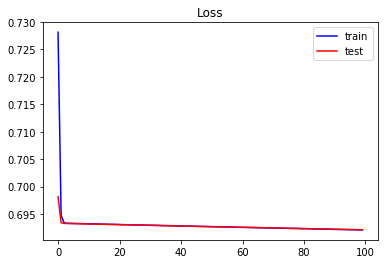

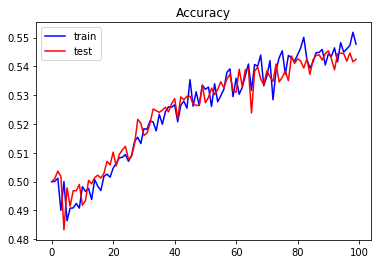

In [15]:
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(test_loss_epoch, 'r', label='test')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(test_acc_epoch, 'r', label='test')
plt.legend()
plt.title("Accuracy")
plt.show()

# Practice
Overfitting? Try to remove some hidden layers or neurons